###V2

In [1]:
import numpy as np, pandas as pd

def fmt_pct(x):
    return f"{100.0*float(x):.1f}%"

def pick_col(df, *names):
    cols = {c.lower(): c for c in df.columns}
    for nm in names:
        if nm.lower() in cols:
            return df[cols[nm.lower()]]
    return None

def ensure_q(m1, m2):
    m1a = np.maximum(m1, m2)
    m2a = np.minimum(m1, m2)
    return m1a, m2a, m1a/m2a

def compute_LambdaTilde(m1, m2, lam1, lam2):
    M = m1 + m2
    return (16.0/13.0)*(((m1+12*m2)*m1**4*lam1) + ((m2+12*m1)*m2**4*lam2))/M**5

In [2]:
# thresholds (seconds)
T_PROMPT = 0.002  # 2 ms
T_SHORT  = 0.005  # 5 ms

def make_labels_A(df):
    ct = df.get("CollapseTime", pd.Series([np.nan]*len(df)))
    rk = df.get("RemnantKey", pd.Series([""]*len(df))).astype(str).str.lower()
    is_prompt = (rk == "prompt") | (pd.notna(ct) & (ct < T_PROMPT))
    return np.where(is_prompt, 0, 1).astype(int)   # 0=PCBH, 1=RNS

def make_labels_B(df):
    """
    Paper-aligned Classifier B:
      0 = PCBH  (tau < 2 ms)
      1 = HMNS  (tau >= 2 ms)  <-- includes both SHORT (2–5 ms) and LONG (>=5 ms)
      2 = NC    (no collapse within simulation time)
    """
    ct = df.get("CollapseTime", pd.Series([np.nan]*len(df)))
    rk = df.get("RemnantKey", pd.Series([""]*len(df))).astype(str).str.lower()

    is_prompt = (rk == "prompt") | (pd.notna(ct) & (ct < T_PROMPT))
    # HMNS = any finite collapse time >= 2 ms (SHORT or LONG)
    is_hmns  = pd.notna(ct) & (ct >= T_PROMPT)
    # NC = explicit no-collapse-like tags OR missing collapse time
    is_nc    = rk.isin({"stable","no_collapse","nocollapse","rns","ns","nc"}) | (ct.isna())

    y = np.full(len(df), 2, dtype=int)   # default NC
    y[is_hmns.values]  = 1              # HMNS (SHORT + LONG)
    y[is_prompt.values]= 0              # PCBH
    return y

def make_labels_C(df):
    ct = df.get("CollapseTime", pd.Series([np.nan]*len(df)))
    rk = df.get("RemnantKey", pd.Series([""]*len(df))).astype(str).str.lower()
    y = np.full(len(df), 3, dtype=int)                                        # 3=NC
    y[(rk == "prompt") | (pd.notna(ct) & (ct < T_PROMPT))] = 0               # 0=PCBH
    y[(pd.notna(ct) & (ct >= T_PROMPT) & (ct < T_SHORT))] = 1                # 1=SHORT
    y[(pd.notna(ct) & (ct >= T_SHORT))] = 2                                   # 2=LONG
    return y

In [3]:
def build_features_from_training(df):
    cols = {c.lower(): c for c in df.columns}
    def get(name, *alts):
        for k in (name,)+alts:
            if k.lower() in cols:
                return df[cols[k.lower()]].astype(float)
        raise KeyError(f"Missing column: {name} (tried {alts})")
    X = pd.DataFrame({
        "Mtot":          get("Mtot"),
        "Mratio_fixed":  get("Mratio","q","Mratio_fixed"),
        "LambdaTilde":   get("LambdaTilde"),
        "ChiEff":        get("ChiEff","chi_eff"),
    }).replace([np.inf,-np.inf], np.nan).dropna()
    return X

In [4]:
def build_features_from_event_csv(path):
    df = pd.read_csv(path)

    # Prefer source frame
    m1 = pick_col(df, "m1_source_frame_Msun","mass_1_source","mass_1")
    m2 = pick_col(df, "m2_source_frame_Msun","mass_2_source","mass_2")
    if m1 is None or m2 is None:
        # fallback: detector frame + redshift if available
        m1 = pick_col(df, "m1_detector_frame_Msun","m1")
        m2 = pick_col(df, "m2_detector_frame_Msun","m2")
        z  = pick_col(df, "redshift","z")
        if (m1 is not None) and (m2 is not None) and (z is not None):
            m1 = m1.astype(float)/(1.0+z.astype(float))
            m2 = m2.astype(float)/(1.0+z.astype(float))
        else:
            raise KeyError("Need source-frame masses; detector-frame requires redshift.")
    m1 = m1.astype(float).values; m2 = m2.astype(float).values
    m1s, m2s, q = ensure_q(m1, m2)

    lam1 = pick_col(df, "Lambda1","lambda1","lambda_1")
    lam2 = pick_col(df, "Lambda2","lambda2","lambda_2")
    if lam1 is None or lam2 is None:
        raise KeyError("Missing Lambda1/Lambda2 in event CSV.")
    lam1 = lam1.astype(float).values; lam2 = lam2.astype(float).values

    chi_eff_series = pick_col(df, "chi_eff","ChiEff")
    if chi_eff_series is not None:
        chi_eff = chi_eff_series.astype(float).values
    else:
        s1z = pick_col(df,"spin_1z","s1z"); s2z = pick_col(df,"spin_2z","s2z")
        if (s1z is not None) and (s2z is not None):
            chi_eff = (m1s*s1z.astype(float).values + m2s*s2z.astype(float).values)/(m1s+m2s)
        else:
            a1 = pick_col(df,"a_1","chi1","spin1"); a2 = pick_col(df,"a_2","chi2","spin2")
            ct1 = pick_col(df,"cos_tilt_1","costilt1"); ct2 = pick_col(df,"cos_tilt_2","costilt2")
            if None in (a1,a2,ct1,ct2):
                raise KeyError("Cannot build chi_eff from provided columns.")
            chi_eff = (m1s*a1.astype(float).values*ct1.astype(float).values +
                       m2s*a2.astype(float).values*ct2.astype(float).values)/(m1s+m2s)

    Mtot = m1s + m2s
    LambdaTilde = compute_LambdaTilde(m1s, m2s, lam1, lam2)

    X = pd.DataFrame({
        "Mtot": Mtot,
        "Mratio_fixed": q,
        "LambdaTilde": LambdaTilde,
        "ChiEff": chi_eff,
    }).replace([np.inf,-np.inf], np.nan).dropna()

    return X

In [5]:
def apply_tsim_filter_for_BC(df, X, y, threshold_ms=25.0):
    # plausible column names:
    cand = ["TsimAfterMerger_ms","tsim_after_merger_ms","PostMergerDuration_ms",
            "SimTimeAfterMerger_ms","tsim_ms","post_merger_ms"]
    tsim = None
    for c in cand:
        if c in df.columns:
            tsim = df[c].astype(float).values
            break
    if tsim is None:
        return X, y  # no-op

    ct = df.get("CollapseTime", pd.Series([np.nan]*len(df))).values
    rk = df.get("RemnantKey", pd.Series([""]*len(df))).astype(str).str.lower().values
    is_nc = np.isnan(ct) | np.isin(rk, ["stable","no_collapse","nocollapse","rns","ns","nc"])
    keep = (~is_nc) | (tsim >= threshold_ms)

    # align to rows left in X
    keep_idx = X.index[keep[X.index]]
    return X.loc[keep_idx], y.loc[keep_idx]

In [6]:
DOMAIN = {
    "A": dict(Mtot=(2.4,3.4), q=(1.0,2.1), LambdaTilde=(89,6255), ChiEff=(-0.267,0.409)),
    "B": dict(Mtot=(2.4,3.4), q=(1.0,2.0), LambdaTilde=(89,6255), ChiEff=(-0.267,0.272)),
    "C": dict(Mtot=(2.4,3.4), q=(1.0,2.0), LambdaTilde=(89,6255), ChiEff=(-0.267,0.272)),
}

def filter_to_domain(X, which):
    r = DOMAIN[which]
    m = (
        X["Mtot"].between(*r["Mtot"]) &
        X["Mratio_fixed"].between(*r["q"]) &
        X["LambdaTilde"].between(*r["LambdaTilde"]) &
        X["ChiEff"].between(*r["ChiEff"])
    )
    return X.loc[m]

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, matthews_corrcoef

def train_gbdt(X, y, random_state=42):
    Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.10, stratify=y, random_state=random_state)
    base = GradientBoostingClassifier(
        random_state=random_state,
        validation_fraction=0.1,
        n_iter_no_change=10,
        tol=1e-4,
    )
    grid = {
        "n_estimators": [120, 160],
        "learning_rate": [0.05, 0.10],
        "max_depth": [2, 3, 4],
        "subsample": [1.0, 0.8],
    }
    gs = GridSearchCV(base, grid, scoring="accuracy", n_jobs=-1, cv=3, refit=True, verbose=0)
    gs.fit(Xtr, ytr)
    mdl = gs.best_estimator_
    yhat = mdl.predict(Xva)
    acc = accuracy_score(yva, yhat)
    mcc = matthews_corrcoef(yva, yhat)
    return mdl, acc, mcc

In [8]:
# --- A ---
dfA = pd.read_json("dataset_classA.json")
XA  = build_features_from_training(dfA)
yA  = pd.Series(make_labels_A(dfA.loc[XA.index]), index=XA.index)
clf_A, accA, mccA = train_gbdt(XA, yA)

# --- B/C (same file) ---
dfBC = pd.read_json("dataset_classBandC.json")
XBC  = build_features_from_training(dfBC)

yB   = pd.Series(make_labels_B(dfBC.loc[XBC.index]), index=XBC.index)
XB_B, yB_B = apply_tsim_filter_for_BC(dfBC, XBC, yB)
clf_B, accB, mccB = train_gbdt(XB_B, yB_B)

yC   = pd.Series(make_labels_C(dfBC.loc[XBC.index]), index=XBC.index)
XB_C, yC_C = apply_tsim_filter_for_BC(dfBC, XBC, yC)
clf_C, accC, mccC = train_gbdt(XB_C, yC_C)

pd.DataFrame({
    "Classifier": ["A","B","C"],
    "Val_Acc":   [accA, accB, accC],
    "Val_MCC":   [mccA, mccB, mccC],
})

,Classifier,Val_Acc,Val_MCC
0,A,1.00000,1.000000
1,B,0.96875,0.946881
2,C,0.93750,0.900929


In [9]:
EVENTS = {
    "GW170817":        "GW170817_result.posterior.csv",
    "GW170817+KN":     "GW170817_KN_result.posterior.csv",
    "GW170817+KN+GRB": "GW170817_KN_GRB_result.posterior.csv",
    "GW190425":        "gw190425_result.posterior.csv",
    "GW170817+EoS":    "EoS.csv"
}

rows = []
for name, path in EVENTS.items():
    Xevt = build_features_from_event_csv(path)

    X_A = filter_to_domain(Xevt, "A")
    X_B = filter_to_domain(Xevt, "B")
    X_C = filter_to_domain(Xevt, "C")

    # keep sample counts so you see how much survived filtering
    nA, nB, nC = len(X_A), len(X_B), len(X_C)

    pA = clf_A.predict_proba(X_A) if nA else np.array([[np.nan, np.nan]])
    pB = clf_B.predict_proba(X_B) if nB else np.array([[np.nan, np.nan, np.nan]])
    pC = clf_C.predict_proba(X_C) if nC else np.array([[np.nan, np.nan, np.nan, np.nan]])

    mA = np.nanmean(pA, axis=0); mB = np.nanmean(pB, axis=0); mC = np.nanmean(pC, axis=0)

    rows.append({
        "Event": name,
        "N_A": nA, "N_B": nB, "N_C": nC,
        "p_PCBH_A": fmt_pct(mA[0]), "p_RNS_A": fmt_pct(mA[1]),
        "p_PCBH_B": fmt_pct(mB[0]), "p_HMNS_B": fmt_pct(mB[1]), "p_NC_B": fmt_pct(mB[2]),
        "p_PCBH_C": fmt_pct(mC[0]), "p_SHORT_C": fmt_pct(mC[1]), "p_LONG_C": fmt_pct(mC[2]), "p_NC_C": fmt_pct(mC[3]),
    })

summary = pd.DataFrame(rows, columns=[
    "Event","N_A","N_B","N_C",
    "p_PCBH_A","p_RNS_A",
    "p_PCBH_B","p_HMNS_B","p_NC_B",
    "p_PCBH_C","p_SHORT_C","p_LONG_C","p_NC_C",
])
summary

,Event,N_A,N_B,N_C,p_PCBH_A,p_RNS_A,p_PCBH_B,p_HMNS_B,p_NC_B,p_PCBH_C,p_SHORT_C,p_LONG_C,p_NC_C
0,GW170817,88659,88659,88659,9.6%,90.4%,13.5%,86.4%,0.2%,14.9%,28.6%,56.3%,0.2%
1,GW170817+KN,5991,5991,5991,1.8%,98.2%,5.3%,94.6%,0.2%,6.0%,30.2%,63.6%,0.2%
2,GW170817+KN+GRB,8649,8649,8649,0.8%,99.2%,4.0%,95.8%,0.1%,4.1%,38.9%,56.8%,0.2%
3,GW190425,61431,61431,61431,98.0%,2.0%,96.1%,3.8%,0.1%,96.8%,0.8%,2.4%,0.1%
4,GW170817+EoS,2799,2799,2799,64.8%,35.2%,64.0%,35.8%,0.2%,64.8%,12.2%,22.8%,0.2%


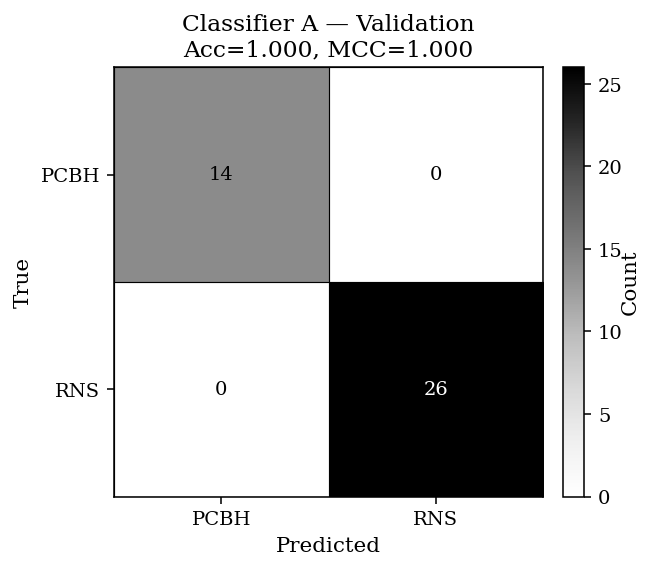

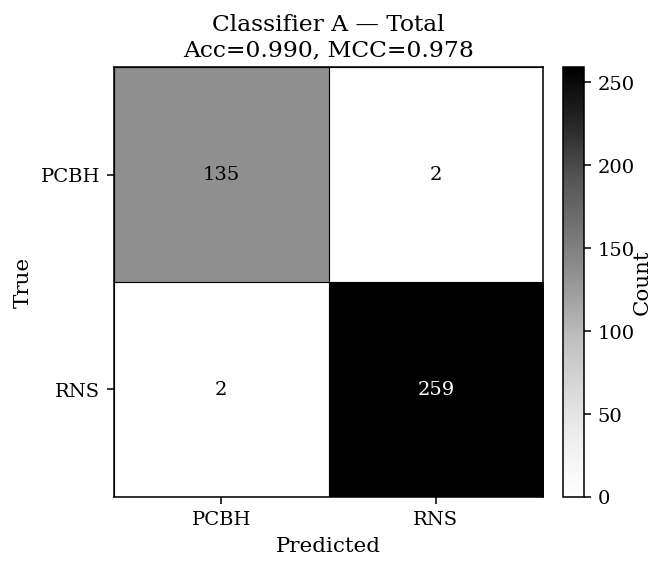

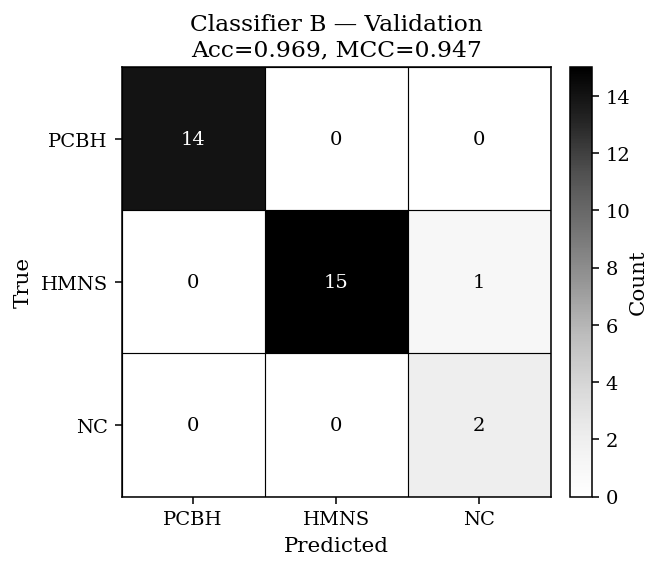

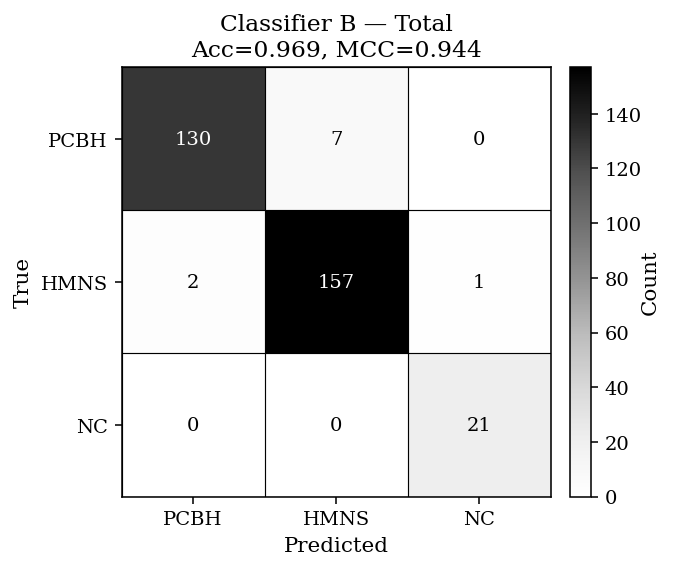

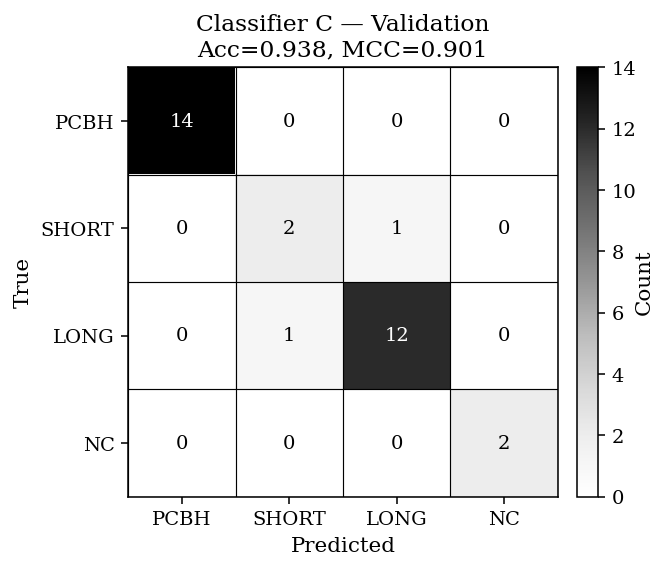

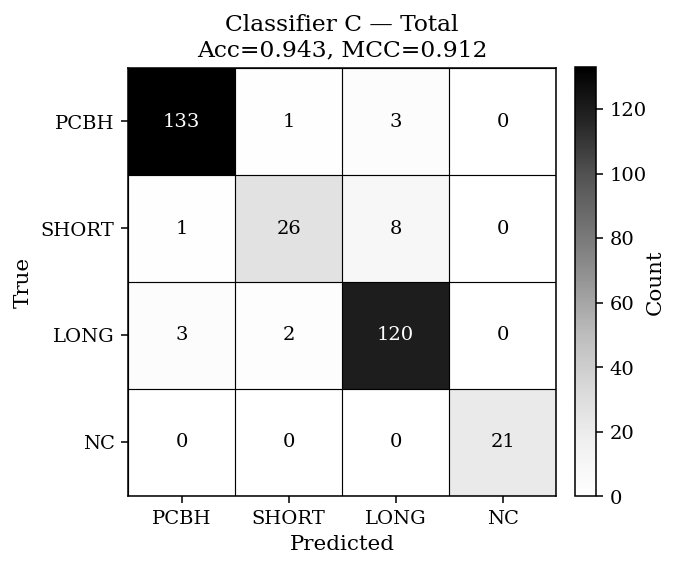

In [10]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, matthews_corrcoef
from sklearn.model_selection import train_test_split

plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "font.family": "serif",
})

def _make_val_split(X, y, random_state=42, test_size=0.10):
    idx = np.arange(len(X))
    _, idx_val = train_test_split(
        idx, test_size=test_size, stratify=y, random_state=random_state
    )
    return idx_val

def _plot_confmat_core(cm, class_names, title, acc, mcc, fname=None):
    fig, ax = plt.subplots(figsize=(4.8, 4.2), dpi=140)
    im = ax.imshow(cm, cmap="Greys", vmin=0, vmax=cm.max())

    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"{title}\nAcc={acc:.3f}, MCC={mcc:.3f}")

    # Grid lines
    for i in range(len(class_names)+1):
        ax.axhline(i-0.5, color="black", lw=0.6)
        ax.axvline(i-0.5, color="black", lw=0.6)

    # Counts in cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            v = cm[i, j]
            color = "white" if v > 0.6 * cm.max() else "black"
            ax.text(j, i, str(v), ha="center", va="center", color=color, fontsize=10)

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("Count", rotation=90, va="center")

    plt.tight_layout()
    if fname:
        plt.savefig(fname, bbox_inches="tight", dpi=200)
    plt.show()

def confusion_matrices_for(model, X, y, class_names, name, random_state=42):
    # Validation split
    idx_val = _make_val_split(X, y, random_state=random_state, test_size=0.10)
    X_val = X.iloc[idx_val]
    y_val = y.iloc[idx_val]

    yhat_val = model.predict(X_val)
    cm_val = confusion_matrix(y_val, yhat_val, labels=range(len(class_names)))

    acc_val = accuracy_score(y_val, yhat_val)
    mcc_val = matthews_corrcoef(y_val, yhat_val)
    _plot_confmat_core(cm_val, class_names, f"{name} — Validation", acc_val, mcc_val)

    # Total dataset
    yhat_tot = model.predict(X)
    cm_tot = confusion_matrix(y, yhat_tot, labels=range(len(class_names)))

    acc_tot = accuracy_score(y, yhat_tot)
    mcc_tot = matthews_corrcoef(y, yhat_tot)
    _plot_confmat_core(cm_tot, class_names, f"{name} — Total", acc_tot, mcc_tot)

# ====== Call for A/B/C ======
confusion_matrices_for(clf_A, XA,   yA,   ["PCBH","RNS"],               "Classifier A")
confusion_matrices_for(clf_B, XB_B, yB_B, ["PCBH","HMNS","NC"],         "Classifier B")
confusion_matrices_for(clf_C, XB_C, yC_C, ["PCBH","SHORT","LONG","NC"], "Classifier C")

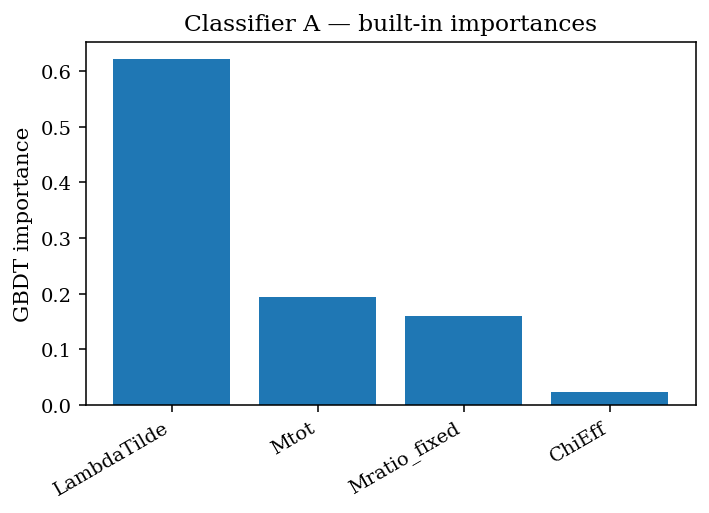

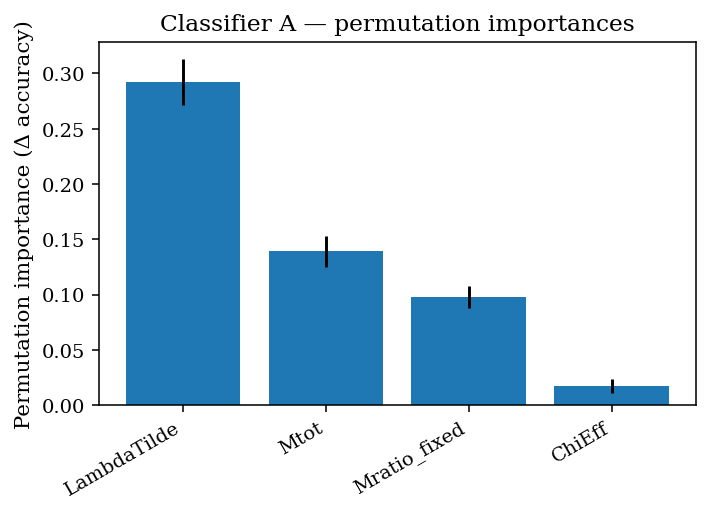

In [16]:
from sklearn.inspection import permutation_importance

def plot_feature_importances(model, feature_names, title, fname=None):
    imp = np.array(model.feature_importances_)
    order = np.argsort(imp)[::-1]
    fig, ax = plt.subplots(figsize=(5.2, 3.8), dpi=140)
    ax.bar(range(len(imp)), imp[order])
    ax.set_xticks(range(len(imp)))
    ax.set_xticklabels([feature_names[i] for i in order], rotation=30, ha="right")
    ax.set_ylabel("GBDT importance")
    ax.set_title(title)
    plt.tight_layout()
    if fname: plt.savefig(fname, bbox_inches="tight", dpi=200)
    plt.show()
FEATURES = XA.columns.tolist()
plot_feature_importances(clf_A, FEATURES, "Classifier A — built‑in importances")

# Permutation importances for A (gives a ‘what really moves accuracy’ view)
perm = permutation_importance(clf_A, XA, yA, n_repeats=30, random_state=42, n_jobs=-1)
perm_means = perm.importances_mean
perm_stds  = perm.importances_std
order = np.argsort(perm_means)[::-1]

fig, ax = plt.subplots(figsize=(5.2, 3.8), dpi=140)
ax.bar(range(len(FEATURES)), perm_means[order], yerr=perm_stds[order])
ax.set_xticks(range(len(FEATURES)))
ax.set_xticklabels([FEATURES[i] for i in order], rotation=30, ha="right")
ax.set_ylabel("Permutation importance (Δ accuracy)")
ax.set_title("Classifier A — permutation importances")
plt.tight_layout(); plt.show()

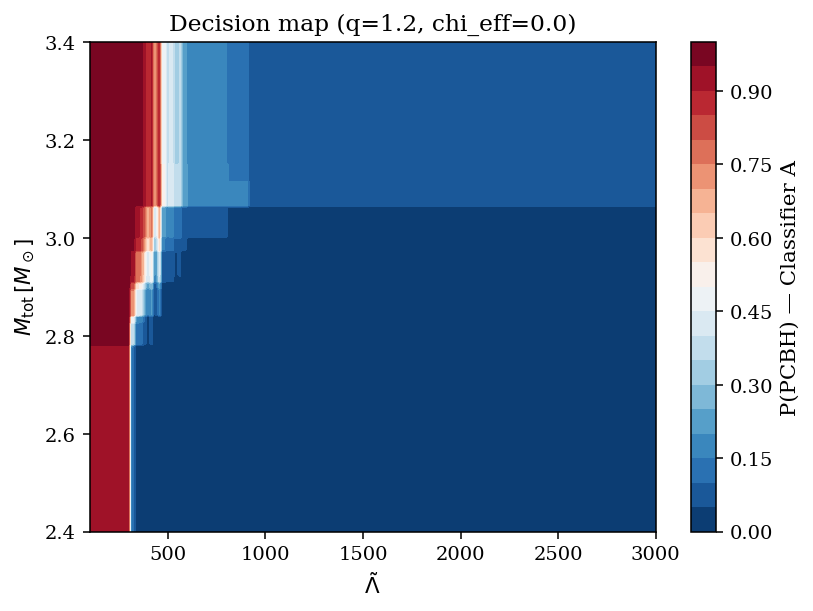

In [12]:
# Grid ranges close to Table I; tweak as you like:
lam_min, lam_max = 100, 3000
mt_min,  mt_max  = 2.4, 3.4

# Fix q and chi_eff to reasonable values for the slice
q_fixed      = 1.2
chieff_fixed = 0.0

lam_grid = np.linspace(lam_min, lam_max, 220)
mt_grid  = np.linspace(mt_min,  mt_max,  220)
LAM, MT  = np.meshgrid(lam_grid, mt_grid)

Xgrid = pd.DataFrame({
    "Mtot": MT.ravel(),
    "Mratio_fixed": np.full(MT.size, q_fixed),
    "LambdaTilde": LAM.ravel(),
    "ChiEff": np.full(MT.size, chieff_fixed),
})

# Keep only points inside A's domain
rng = DOMAIN["A"]
mask = (
    Xgrid["Mtot"].between(*rng["Mtot"]) &
    Xgrid["Mratio_fixed"].between(*rng["q"]) &
    Xgrid["LambdaTilde"].between(*rng["LambdaTilde"]) &
    Xgrid["ChiEff"].between(*rng["ChiEff"])
)
probs = np.full(Xgrid.shape[0], np.nan)
probs[mask.values] = clf_A.predict_proba(Xgrid.loc[mask])[:,0]  # class 0 = PCBH

Z = probs.reshape(MT.shape)

fig, ax = plt.subplots(figsize=(6.0, 4.5), dpi=140)
cs = ax.contourf(LAM, MT, Z, levels=np.linspace(0,1,21), cmap="RdBu_r")
cbar = fig.colorbar(cs, ax=ax)
cbar.set_label("P(PCBH) — Classifier A")
ax.set_xlabel(r"$\tilde{\Lambda}$")
ax.set_ylabel(r"$M_{\mathrm{tot}}\,[M_\odot]$")
ax.set_title(f"Decision map (q={q_fixed}, chi_eff={chieff_fixed})")
plt.tight_layout(); plt.show()

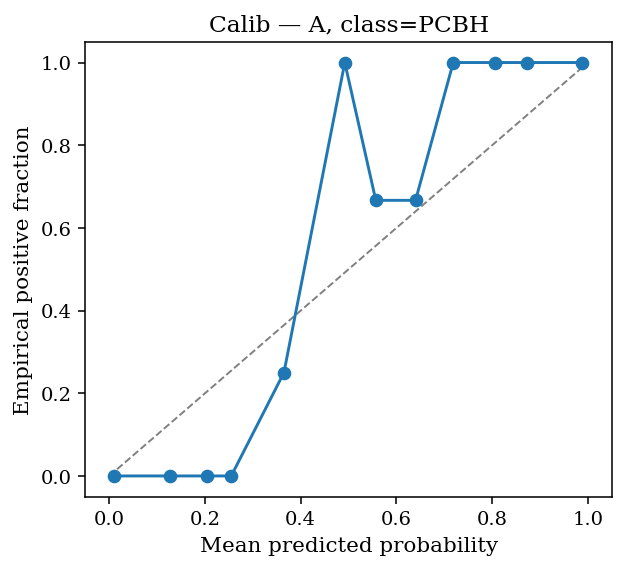

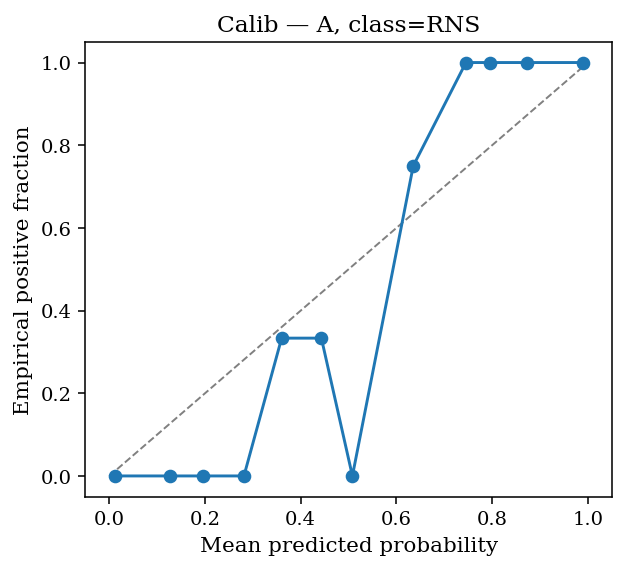

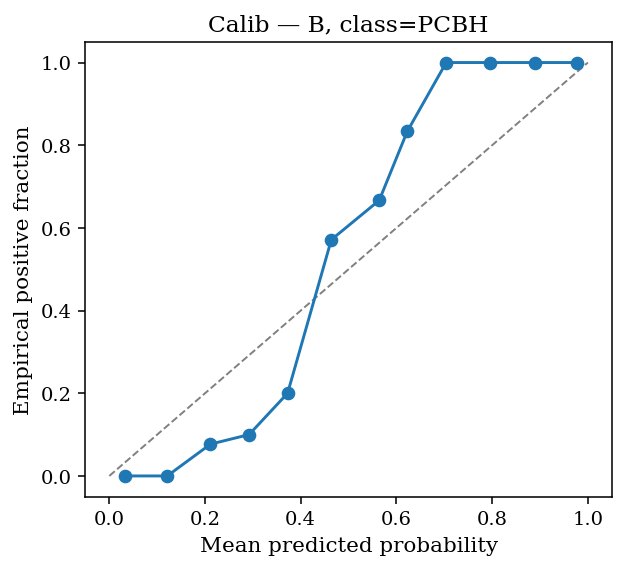

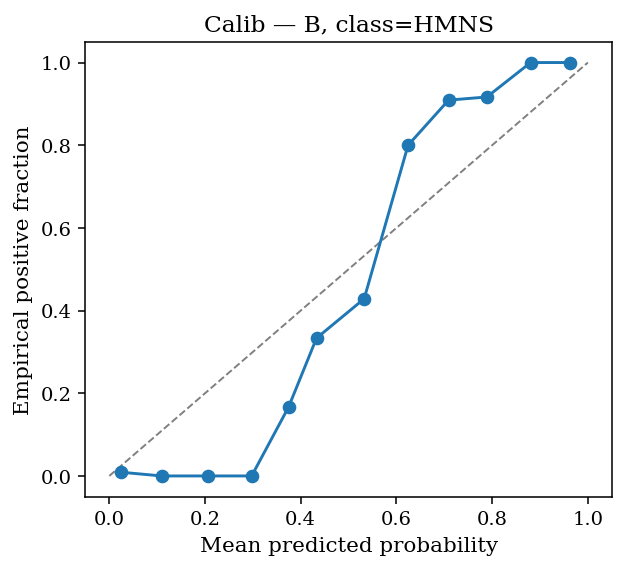

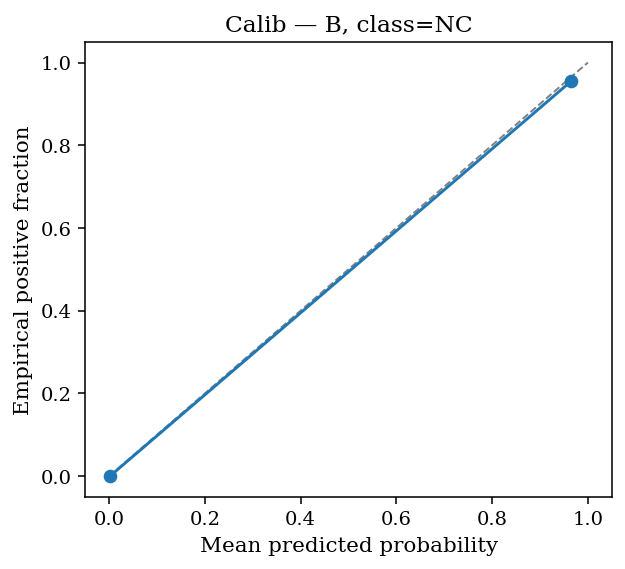

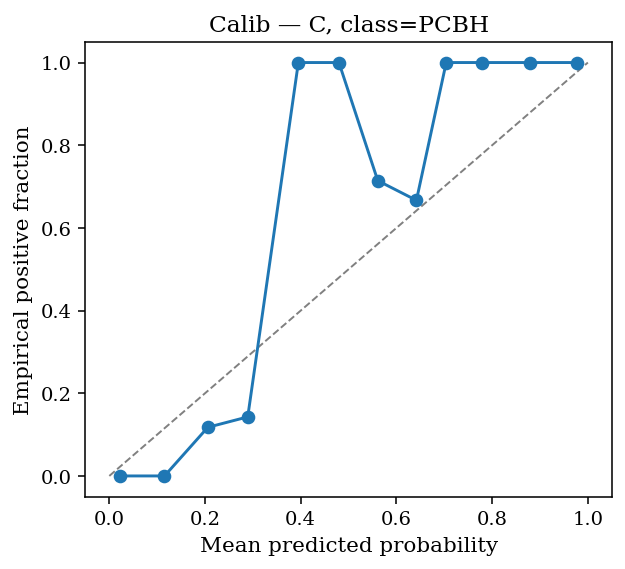

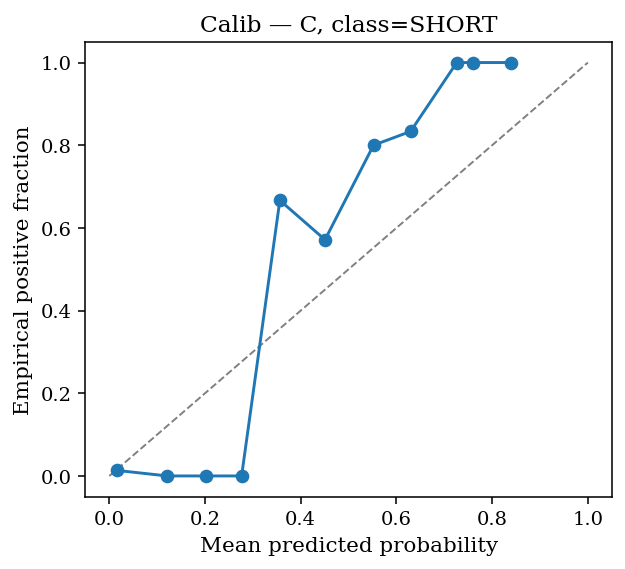

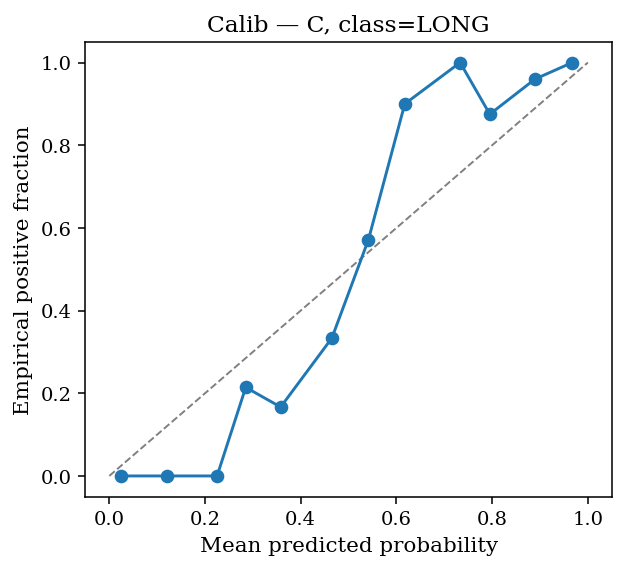

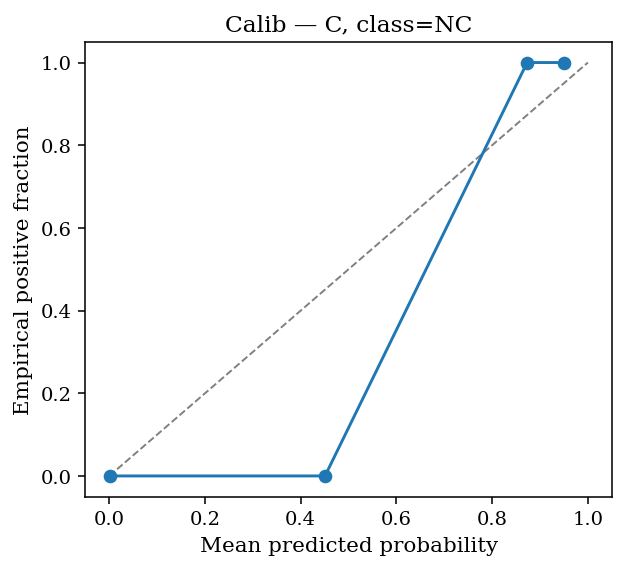

In [13]:
from sklearn.calibration import calibration_curve

def reliability_curve(model, X, y, class_id=0, bins=12, title=""):
    proba = model.predict_proba(X)[:, class_id]
    # True: class_id vs rest
    y_bin = (y.values == class_id).astype(int)
    frac_pos, mean_pred = calibration_curve(y_bin, proba, n_bins=bins, strategy="uniform")
    fig, ax = plt.subplots(figsize=(4.6,4.2), dpi=140)
    ax.plot([0,1], [0,1], "--", color="gray", lw=1)
    ax.plot(mean_pred, frac_pos, marker="o")
    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Empirical positive fraction")
    ax.set_title(title)
    plt.tight_layout(); plt.show()

# A: check class 0 (PCBH) and class 1 (RNS)
reliability_curve(clf_A, XA, yA, class_id=0, title="Calib — A, class=PCBH")
reliability_curve(clf_A, XA, yA, class_id=1, title="Calib — A, class=RNS")

# B: PCBH / HMNS / NC one‑vs‑rest
for cid, cname in enumerate(["PCBH","HMNS","NC"]):
    reliability_curve(clf_B, XB_B, yB_B, class_id=cid, title=f"Calib — B, class={cname}")

# C: PCBH / SHORT / LONG / NC one‑vs‑rest
for cid, cname in enumerate(["PCBH","SHORT","LONG","NC"]):
    reliability_curve(clf_C, XB_C, yC_C, class_id=cid, title=f"Calib — C, class={cname}")

/tmp/ipython-input-825802200.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vals = df[cols].applymap(pct_to_float).values


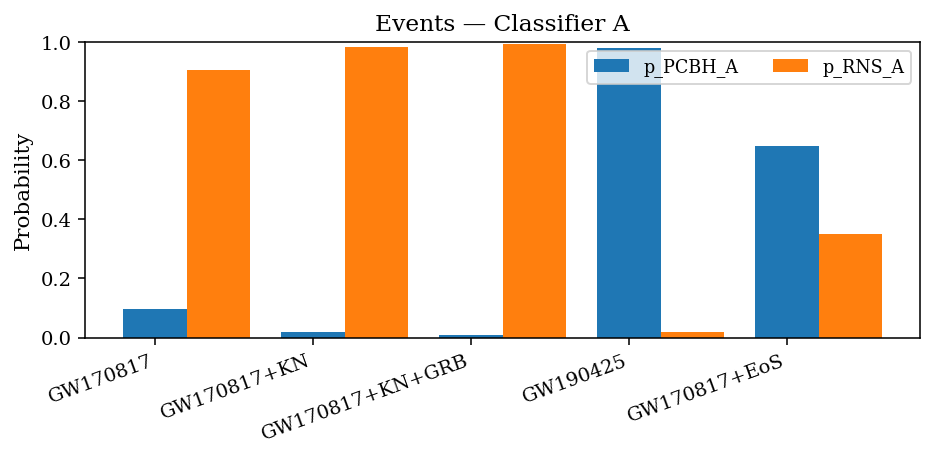

/tmp/ipython-input-825802200.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vals = df[cols].applymap(pct_to_float).values


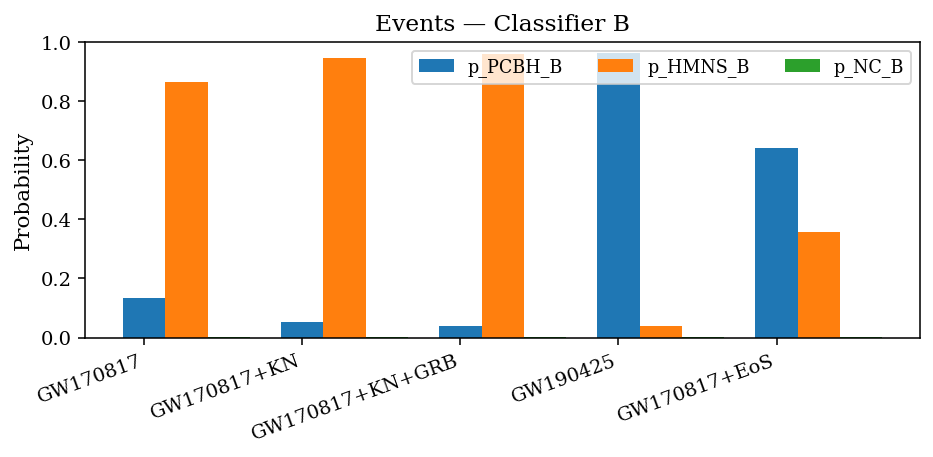

/tmp/ipython-input-825802200.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vals = df[cols].applymap(pct_to_float).values


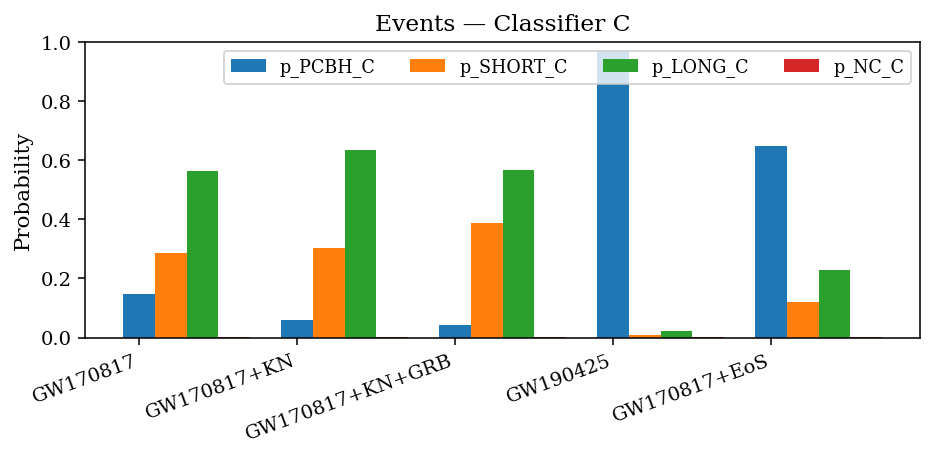

In [14]:
# uses your 'summary' DataFrame built earlier
import matplotlib.pyplot as plt
import numpy as np

def pct_to_float(s):  # convert "41.7%" -> 0.417
    return float(str(s).strip("%"))/100.0

plot_cols_A = ["p_PCBH_A","p_RNS_A"]
plot_cols_B = ["p_PCBH_B","p_HMNS_B","p_NC_B"]
plot_cols_C = ["p_PCBH_C","p_SHORT_C","p_LONG_C","p_NC_C"]

def bar_block(df, cols, title):
    vals = df[cols].applymap(pct_to_float).values
    x = np.arange(len(df))
    w = 0.8/len(cols)
    fig, ax = plt.subplots(figsize=(6.8, 3.4), dpi=140)
    for i,c in enumerate(cols):
        ax.bar(x + i*w - 0.4 + w*len(cols)/2, vals[:,i], width=w, label=c)
    ax.set_xticks(x); ax.set_xticklabels(df["Event"], rotation=20, ha="right")
    ax.set_ylim(0,1)
    ax.set_ylabel("Probability")
    ax.set_title(title)
    ax.legend(ncol=len(cols), fontsize=9)
    plt.tight_layout(); plt.show()

bar_block(summary, plot_cols_A, "Events — Classifier A")
bar_block(summary, plot_cols_B, "Events — Classifier B")
bar_block(summary, plot_cols_C, "Events — Classifier C")

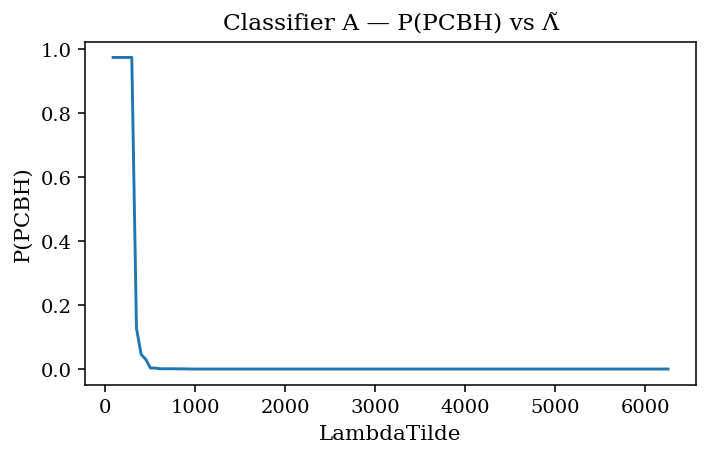

In [17]:
from sklearn.inspection import partial_dependence

def pdp_1d_A(feature_name, grid=None, fixed=None, title=None):
    idx = FEATURES.index(feature_name)
    # Base point: medians from XA
    base = XA.median().to_dict()
    if fixed:
        base.update(fixed)

    # Build samples varying one feature
    if grid is None:
        lo, hi = DOMAIN["A"]["LambdaTilde"] if feature_name=="LambdaTilde" else (XA[feature_name].min(), XA[feature_name].max())
        grid = np.linspace(lo, hi, 120)

    Xp = pd.DataFrame({k: np.full_like(grid, float(v), dtype=float) for k,v in base.items()})
    Xp[feature_name] = grid
    proba = clf_A.predict_proba(Xp)[:,0]  # PCBH

    fig, ax = plt.subplots(figsize=(5.2,3.4), dpi=140)
    ax.plot(grid, proba)
    ax.set_xlabel(feature_name); ax.set_ylabel("P(PCBH)")
    ax.set_title(title or f"PDP — A: vary {feature_name}")
    plt.tight_layout(); plt.show()

# Example: vary Λ̃ at fixed q and chi_eff, using median Mtot
pdp_1d_A("LambdaTilde", fixed={"Mtot": float(XA["Mtot"].median()),
                               "Mratio_fixed": 1.2, "ChiEff": 0.0},
         title="Classifier A — P(PCBH) vs Λ̃")

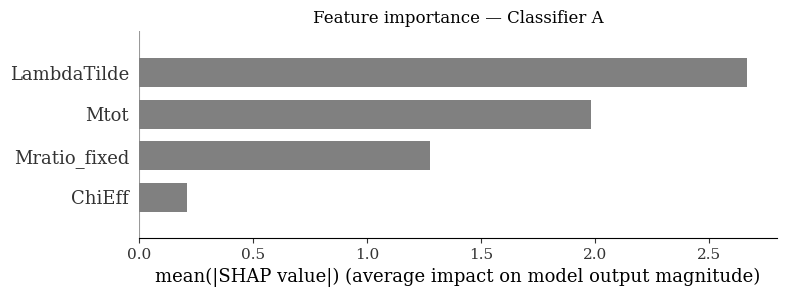

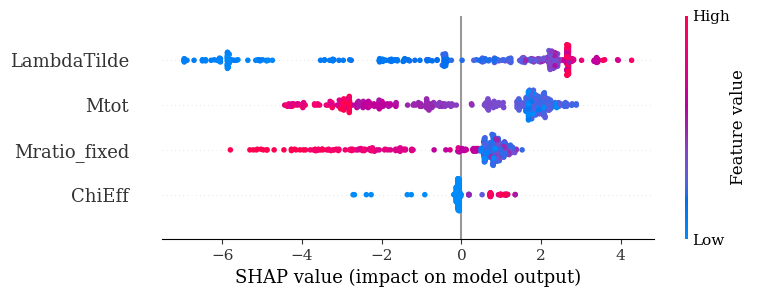

In [18]:
import shap
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "font.family": "serif"
})

# SHAP for Classifier A
explainer_A = shap.TreeExplainer(clf_A)
shap_values_A = explainer_A.shap_values(XA)

# Bar plot of mean(|SHAP|)
shap.summary_plot(
    shap_values_A, XA,
    plot_type="bar",
    color="grey",
    max_display=len(XA.columns),
    show=False
)
plt.title("Feature importance — Classifier A", fontsize=12)
plt.tight_layout()
plt.show()

# Optional: dot plot (effect + distribution)
shap.summary_plot(
    shap_values_A, XA,
    max_display=len(XA.columns)
)

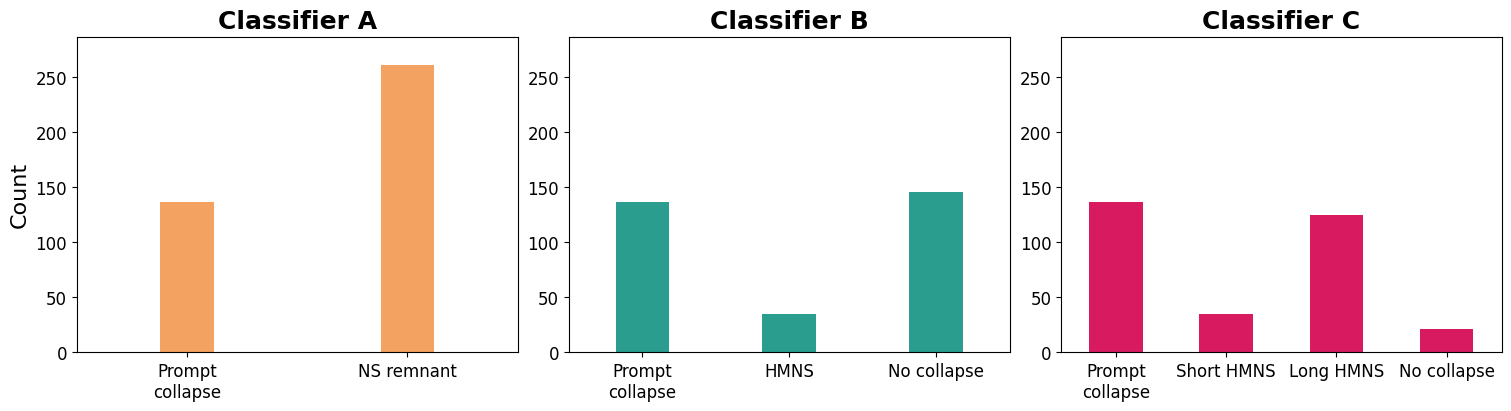

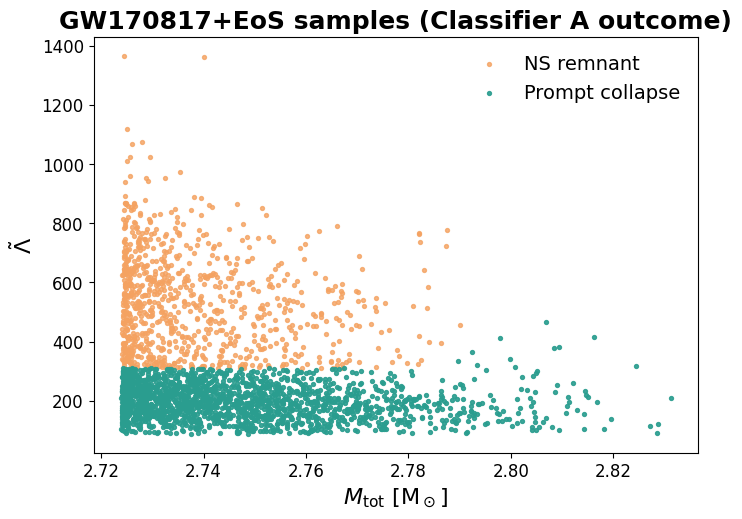

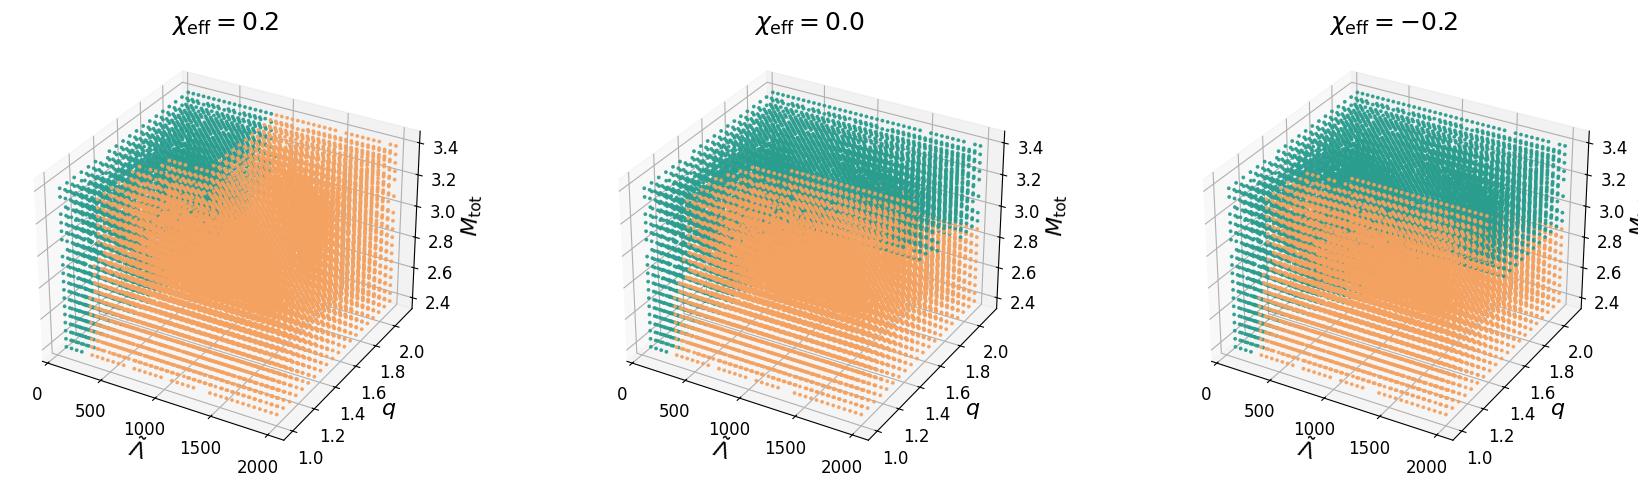

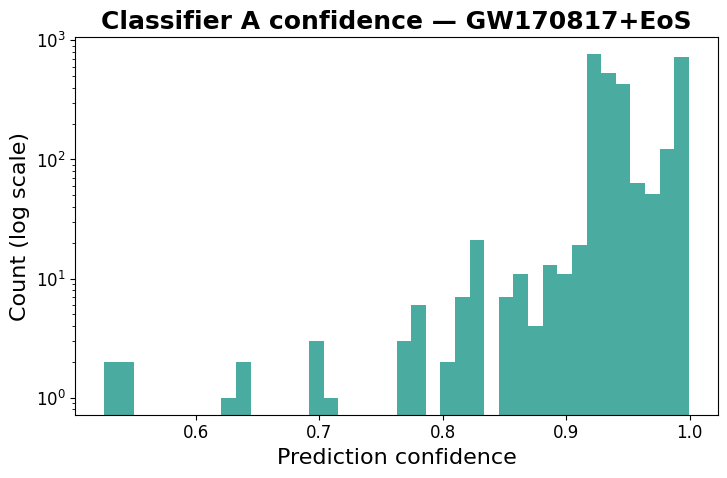

In [31]:
# =======================
# Paper-style figures
# =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ---------- styling (paper-ish) ----------
rcParams.update({
    "font.size": 14,
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.figsize": (7, 5),
    "font.family": "DejaVu Sans",
})

# brand colors close to the paper
COL_A = "#f4a261"  # orange
COL_B = "#2a9d8f"  # teal
COL_C = "#d81b60"  # magenta
GREY  = "#6c757d"

# ---------- tiny helpers ----------
def count_per_class(y, labels_order=None):
    s = pd.Series(y).value_counts().sort_index()
    if labels_order is None:
        return s.index.values, s.values
    vals = [s.get(i, 0) for i in labels_order]
    return labels_order, np.array(vals)

def predict_A_labels(X):
    # A: 0=PCBH, 1=RNS
    return clf_A.predict(filter_to_domain(X, "A"))

def predict_A_probas(X):
    XA = filter_to_domain(X, "A")
    if len(XA) == 0:
        return np.array([]), np.array([])
    p = clf_A.predict_proba(XA)
    y = p.argmax(axis=1)
    conf = p.max(axis=1)
    return y, conf

# =========================================================
# Figure: class histograms for A, B, C (training sets)
# =========================================================


# --- helper: constant pixel-width bars ---------------------------------------
def _data_width_from_points(ax, width_pt=24):
    """Convert a bar width given in points to data units for the current axes."""
    fig = ax.figure
    # points -> pixels
    width_px = width_pt * fig.dpi / 72.0
    # how many data-x units correspond to `width_px` pixels?
    x0_px = ax.transData.transform((0, 0))[0]
    x1_px = x0_px + width_px
    x0_data = ax.transData.inverted().transform((x0_px, 0))[0]
    x1_data = ax.transData.inverted().transform((x1_px, 0))[0]
    return x1_data - x0_data

def bar_same_pixel_width(ax, counts, labels, color, title, width_pt=24):
    x = np.arange(len(counts))
    w = _data_width_from_points(ax, width_pt=width_pt)
    ax.bar(x, counts, width=w, color=color, edgecolor="none", align="center")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_title(title)
    # small horizontal padding so ends don’t get clipped
    ax.set_xlim(-0.5, len(counts)-0.5)

# --- build counts exactly as you already do (cnts_A, cnts_B, cnts_C, labels_*) ---
# (keeping your existing code that computes yA_train/yB_train/yC_train and cnts)

fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

bar_same_pixel_width(axes[0], cnts_A, labels_A, COL_A, "Classifier A", width_pt=60)
bar_same_pixel_width(axes[1], cnts_B, labels_B, COL_B, "Classifier B", width_pt=90)
bar_same_pixel_width(axes[2], cnts_C, labels_C, COL_C, "Classifier C", width_pt=120)

# optional: common ymax so heights are comparable
ymax = 1.10 * max(max(cnts_A), max(cnts_B), max(cnts_C))
for ax in axes:
    ax.set_ylim(0, ymax)
axes[0].set_ylabel("Count")

plt.show()
# =======================================================================
# Fig: GW170817+EoS scatter (LambdaTilde vs Mtot) colored by
#                  Classifier A prediction (NS remnant vs Prompt collapse)
# =======================================================================
try:
    X_eos = build_features_from_event_csv("EoS.csv")
    XA_eos = filter_to_domain(X_eos, "A")
    y_pred_A = clf_A.predict(XA_eos)  # 0=PCBH, 1=RNS
    is_rns = (y_pred_A == 1)
    is_bh  = (y_pred_A == 0)

    fig, ax = plt.subplots(figsize=(7.8, 5.4))
    ax.scatter(XA_eos.loc[is_rns, "Mtot"], XA_eos.loc[is_rns, "LambdaTilde"],
               s=8, c=COL_A, alpha=0.8, label="NS remnant")
    ax.scatter(XA_eos.loc[is_bh,  "Mtot"], XA_eos.loc[is_bh,  "LambdaTilde"],
               s=8, c=COL_B, alpha=0.9, label="Prompt collapse")
    ax.set_xlabel(r"$M_{\rm tot}\ [{\rm M_\odot}]$")
    ax.set_ylabel(r"$\tilde{\Lambda}$")
    ax.legend(frameon=False, loc="upper right")
    ax.set_title("GW170817+EoS samples (Classifier A outcome)")
    plt.show()
except Exception as e:
    print("Skipping Fig.5-like scatter (need EoS.csv parsed by your builder):", e)

# ===================================================================================
# Fig: 3D outcome maps for Classifier A over (LambdaTilde, q, Mtot)
#                  at chi_eff = +0.2, 0.0, -0.2
# ===================================================================================
def grid_for_A(chi_eff=0.0,
               Mtot_rng=(2.4, 3.4), q_rng=(1.0, 2.1), lam_rng=(89, 2000),
               nM=20, nq=20, nlam=40):
    Mgrid = np.linspace(*Mtot_rng, nM)
    qgrid = np.linspace(*q_rng, nq)
    Lam   = np.linspace(*lam_rng, nlam)
    MM, QQ, LL = np.meshgrid(Mgrid, qgrid, Lam, indexing="ij")
    # make synthetic m1,m2 from Mtot & q (source-frame); build LambdaTilde directly
    # we only need features, so: Mtot = M, Mratio_fixed = q, LambdaTilde = LL, ChiEff = chi_eff
    Xg = pd.DataFrame({
        "Mtot": MM.ravel(),
        "Mratio_fixed": QQ.ravel(),
        "LambdaTilde": LL.ravel(),
        "ChiEff": np.full(MM.size, chi_eff)
    })
    return Xg, MM.shape

def plot_3d_panel(chi_eff, ax):
    Xg, shape = grid_for_A(chi_eff=chi_eff)
    Xg = filter_to_domain(Xg, "A")
    if len(Xg) == 0:
        ax.text2D(0.05, 0.5, "No points in domain", transform=ax.transAxes)
        return
    y = clf_A.predict(Xg)  # 0=PCBH, 1=RNS
    # Thin points for speed/draw
    if len(Xg) > 15000:
        keep = np.random.default_rng(42).choice(len(Xg), 15000, replace=False)
        Xg = Xg.iloc[keep]
        y  = y[keep]
    c = np.where(y==1, COL_A, COL_B)  # RNS=orange, PCBH=teal
    ax.scatter(Xg["LambdaTilde"], Xg["Mratio_fixed"], Xg["Mtot"], c=c, s=3, alpha=0.9)
    ax.set_xlabel(r"$\tilde{\Lambda}$")
    ax.set_ylabel(r"$q$")
    ax.set_zlabel(r"$M_{\rm tot}$")
    ax.set_title(rf"$\chi_{{\rm eff}} = {chi_eff}$")

fig = plt.figure(figsize=(18, 5))
for i, ce in enumerate([0.2, 0.0, -0.2], 1):
    ax = fig.add_subplot(1, 3, i, projection="3d")
    plot_3d_panel(ce, ax)
plt.tight_layout()
plt.show()

# ==================================================================================
# Fig: prediction confidence for Classifier A on GW170817+EoS samples
# ==================================================================================
try:
    X_eos = build_features_from_event_csv("EoS.csv")
    XA_eos = filter_to_domain(X_eos, "A")
    if len(XA_eos):
        p = clf_A.predict_proba(XA_eos)
        conf = p.max(axis=1)
        fig, ax = plt.subplots(figsize=(7.5, 5))
        ax.hist(conf, bins=40, color=COL_B, alpha=0.85)
        ax.set_yscale("log")
        ax.set_xlabel("Prediction confidence")
        ax.set_ylabel("Count (log scale)")
        ax.set_title("Classifier A confidence — GW170817+EoS")
        plt.tight_layout()
        plt.show()
    else:
        print("No GW170817+EoS samples inside A-domain — confidence plot skipped.")
except Exception as e:
    print("Skipping confidence plot (need EoS.csv parsed by your builder):", e)